## Modules à importer

In [94]:
import math
import glob
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from snprop import age
from scipy import stats
from pymage import query
from variaIa import tools_ar
from snprop import survey, tools
from variaIa.tools_ar import surveys, df_cons, df_nc, df_c, df_full
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp2d as spline
from matplotlib.lines import Line2D
from pprint import PrettyPrinter
from variaIa import stretchevol
from variaIa import massevol
from importlib import reload

#### Colormap definition

In [3]:
# create colormap
# ---------------

# create a colormap that consists of
# - 1/5 : custom colormap, ranging from white to the first color of the colormap
# - 4/5 : existing colormap

# set upper part: 4 * 256/4 entries
upper = mpl.cm.turbo(np.arange(256))

# set lower part: 1 * 256/4 entries
# - initialize all entries to 1 to make sure that the alpha channel (4th column) is 1
lower = np.ones((int(256/4),4))
# - modify the first three columns (RGB):
#   range linearly between white (1,1,1) and the first color of the upper colormap
for i in range(3):
    lower[:,i] = np.linspace(1, upper[0,i], lower.shape[0])

# combine parts of colormap
cmap = np.vstack((lower, upper))

# convert to matplotlib colormap
cmap_tpw = mpl.colors.ListedColormap(cmap, name='turbopw', N=cmap.shape[0])

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [4]:
def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools_ar.cons, su=tools_ar.su)
display(int_set_su)

smap = plt.cm.get_cmap('cividis')
#smap = plt.cm.get_cmap('viridis')
colors = {'SNF': plt.cm.binary(0.9),
          'low-z': (1, 0, 0),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300),  # for viridis
          'All': (255/255, 51/255, 0/255)} 

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']
df_nlowz = df_nc[df_nc['survey'] != 'low-z']

interactive(children=(Checkbox(value=False, description='Conservative'), Dropdown(description='Survey:', optio…

#### Check FITPROB density

In [58]:
d = pd.read_csv('../../../Data/sne/data_cheat.csv', sep=' ', index_col='CID')

[0.00104288, 0.00100543, 7.54696e-19]

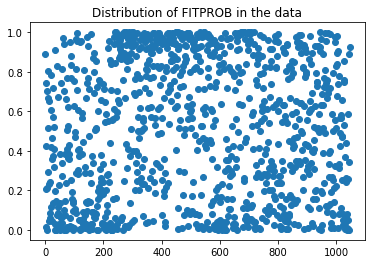

In [59]:
plt.scatter([i for i in range(len(d['FITPROB']))], d['FITPROB'])
plt.title('Distribution of FITPROB in the data')
plt.savefig('../../../Images/pdf/data_fitprob_distrib.pdf', bbox_inches='tight')
[np.min(d[d['IDSURVEY'] == i]['FITPROB']) for i in [1, 15, 4]]

[1.375, 1.787, 1.452]

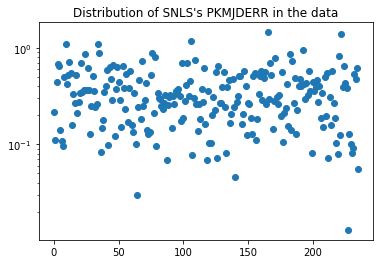

In [77]:
plt.scatter([i for i in range(len(d[d['IDSURVEY'] == 4]['PKMJDERR']))],
            d[d['IDSURVEY'] == 4]['PKMJDERR'])
plt.yscale('log')
plt.title("Distribution of SNLS's PKMJDERR in the data")
plt.savefig('../../../Images/pdf/data_snls_fitprob_distrib.pdf', bbox_inches='tight')
[np.max(d[d['IDSURVEY'] == i]['PKMJDERR']) for i in [1, 15, 4]]

In [66]:
d[d['FITPROB'] < 1e-18]

,CIDint,IDSURVEY,TYPE,FIELD,CUTFLAG_SNANA,zCMB,zCMBERR,zHD,zHDERR,VPEC,...,MURES,MUPULL,ERRCODE,biasCor_mu,biasCorErr_mu,biasCor_mB,biasCor_x1,biasCor_c,biasScale_muCOV,IDSAMPLE
CID,,,,,,,,,,,,,,,,,,,,,
04D4im,52,4,0,D4,1,0.74991,0.0,0.74909,0.0,-245.755,...,-0.129,-0.671,0,-0.104,0.009,-0.001,0.197,0.036,0.557,3


[3.4662900000000005e-08, 0.000564641, 6.57703e-05]

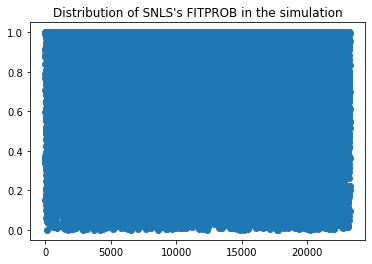

In [62]:
plt.scatter([i for i in range(len(fitprop[fitprop['IDSURVEY'] == 4]['FITPROB']))],
            fitprop[fitprop['IDSURVEY'] == 4]['FITPROB'])
plt.title("Distribution of SNLS's FITPROB in the simulation")
plt.savefig('../../../Images/pdf/sim_snls_fitprob_distrib.pdf', bbox_inches='tight')
[np.min(fitprop[fitprop['IDSURVEY'] == i]['FITPROB']) for i in [1, 15, 4]]

In [47]:
len(d[(d['IDSURVEY'] == 4) & (d['zCMB'] < 0.60) & (d['FITPROB'] < 1e-3)])

9

## First `SNANA` implementation

In [5]:
fitprop = pd.read_csv('../../../Data/sims/First_run/FITOPT000.FITRES', sep=' ')

In [19]:
fitprop.columns

Index(['CID', 'CIDint', 'IDSURVEY', 'TYPE', 'FIELD', 'CUTFLAG_SNANA', 'zHEL',
       'zHELERR', 'zCMB', 'zCMBERR', 'zHD', 'zHDERR', 'VPEC', 'VPECERR',
       'MWEBV', 'HOST_LOGMASS', 'HOST_LOGMASS_ERR', 'HOST_sSFR',
       'HOST_sSFR_ERR', 'SNRMAX1', 'SNRMAX2', 'SNRMAX3', 'PKMJD', 'PKMJDERR',
       'x1', 'x1ERR', 'c', 'cERR', 'mB', 'mBERR', 'x0', 'x0ERR', 'COV_x1_c',
       'COV_x1_x0', 'COV_c_x0', 'NDOF', 'FITCHI2', 'FITPROB', 'SIM_TYPE_INDEX',
       'SIM_TEMPLATE_INDEX', 'SIM_LIBID', 'SIM_NGEN_LIBID', 'SIM_ZCMB',
       'SIM_ZFLAG', 'SIM_VPEC', 'SIM_DLMAG', 'SIM_PKMJD', 'SIM_x1', 'SIM_c',
       'SIM_alpha', 'SIM_beta', 'SIM_x0', 'SIM_mB', 'SIM_AV', 'SIM_RV',
       'SIM_HOSTLIB_sSFR', 'SIM_gammaDM', 'PROB_UNITY', 'Unnamed: 58'],
      dtype='object')

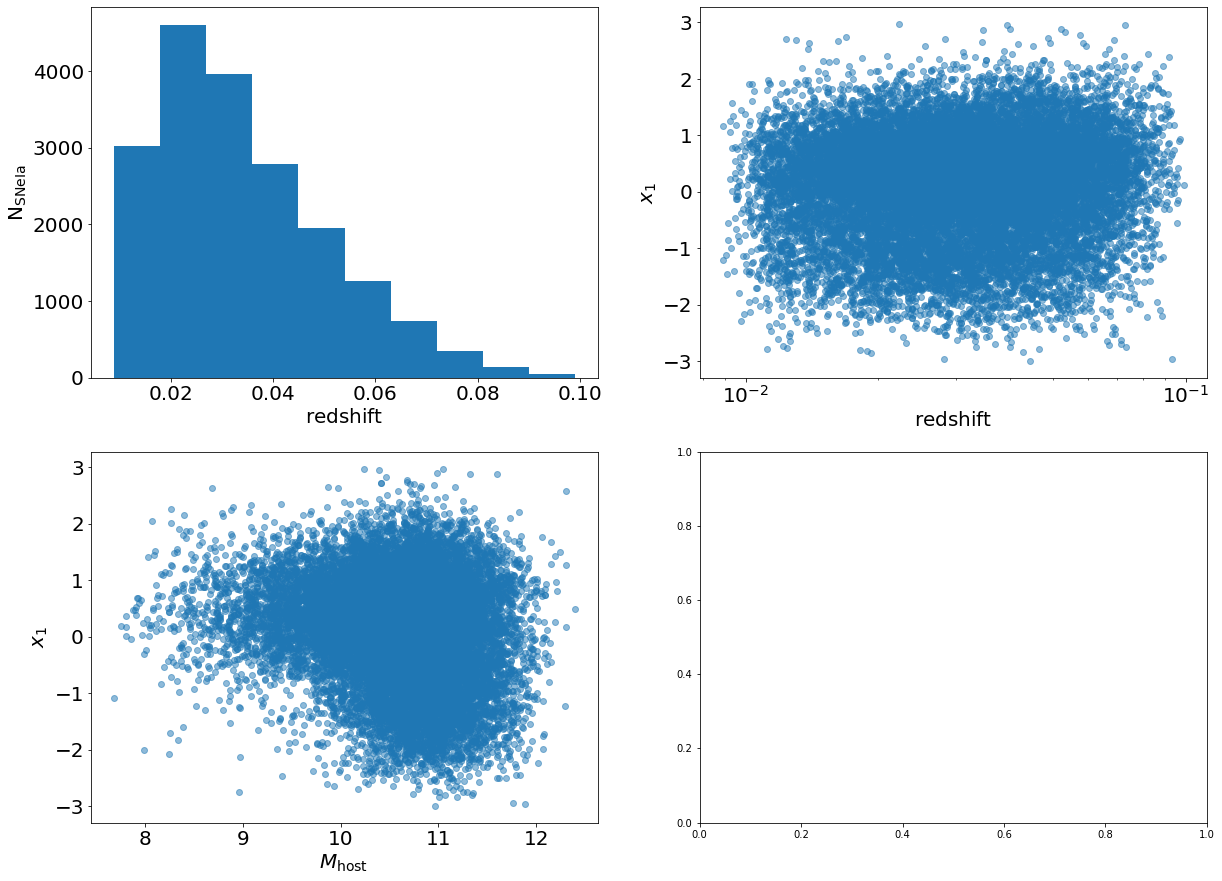

In [33]:
#fig = plt.figgure(figsize=[8, 5])
#ax1 = plt.subplots(121)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[20, 15])

#fig = plt.figure(figsize=[8, 5])
#ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

ax1.hist(fitprop.zCMB.values)
ax2.scatter(fitprop.zCMB.values, fitprop.x1.values, alpha=.5)
ax2.set_xscale('log')
ax3.scatter(fitprop.HOST_LOGMASS, fitprop.x1, alpha=.5)

ax1.tick_params(labelsize=20)
ax2.tick_params(labelsize=20)
ax3.tick_params(labelsize=20)

ax1.set_xlabel(r"$\mathrm{redshift}$ ", fontsize=20)
ax1.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)

ax2.set_xlabel(r"$\mathrm{redshift}$ ", fontsize=20)
ax2.set_ylabel(r"$x_1$", fontsize=20)

ax3.set_xlabel(r"$M_\mathrm{host}$ ", fontsize=20)
ax3.set_ylabel(r"$x_1$", fontsize=20)

fig.savefig('../../../Images/pdf/fitprop_test.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/fitprop_test.png', bbox_inches='tight', dpi=600)

## Second `SNANA` implementation: with HOSTLIB magshift=0.70

### Choose simu

In [5]:
sim_path = glob.glob("../../../Data/sims/NN*")
sc = ipw.Dropdown(options=sim_path,
                  description='Sim choice',
                  value=sim_path[0])

def set_fitprop(path):
    global fitprop_data
    if len(glob.glob(path + '/fitprop_data')) == 0:
        fitprop_data = []
    else:
        with open(path + '/fitprop_data', 'rb') as f:
            fitprop_data = pickle.load(f)

ipw.interactive(set_fitprop, path=sc)

interactive(children=(Dropdown(description='Sim choice', options=('../../../Data/sims/NN_G10_PANTH_V0', '../..…

### Convert `.fitres`

In [7]:
outputs = glob.glob(sc.value + '/PIP*/FITOPT000[!_treated]*')
fitprops = []
for i, output in enumerate(outputs):
    fitres = open(output, 'r+')
    fitres_lines = fitres.readlines()
    fitres.close()
    
    del(fitres_lines[8])
    del(fitres_lines[:7])
    fitres_lines[0] = fitres_lines[0][11:]
    fitres_lines[1:] = [line[4:] for line in fitres_lines[1:]]
    
    fitres = open(output.split('.FITRES')[0] + '_treated' + '.FITRES', 'w+')
    for line in fitres_lines:
        fitres.write(line)
    fitres.close() 
    fitprops.append(pd.read_csv(output.split('.FITRES')[0] + '_treated' + '.FITRES', sep=' '))
fitprop = fitprops[0]
for i in range(1, len(fitprops)):
    fitprop = fitprop.append(fitprops[i])

### Load selected

In [5]:
outputs = glob.glob(sc.value + '/PIP*/FITOPT000[!_treated]*')
fitprops = []
for output in outputs:
    fitprops.append(pd.read_csv(output.split('.FITRES')[0] + '_treated' + '.FITRES', sep=' '))
fitprop = fitprops[0]
for i in range(1, len(fitprops)):
    fitprop = fitprop.append(fitprops[i])

### Apply `x_1`, `c` cuts

In [68]:
np.max(fitprop['PKMJDERR'])

8.225

In [69]:
np.max(d['PKMJDERR'])

1.901

In [70]:
fitprop = fitprop[(fitprop['x1'] > -3.0) & (fitprop['x1'] < 3.0) &
                  (fitprop['x1ERR'] < 1.0) &
                  (fitprop['c'] > -0.3) & (fitprop['c'] < 0.3) &
                  (fitprop['PKMJDERR'] < 2.0)]

### Get data ratio

In [49]:
surveys_size = {survey: len(df_full[df_full['survey'] == survey])
                for survey in ['SDSS', 'PS1', 'SNLS']}

In [71]:
fitprop_size = {survey: len(fitprop[fitprop['IDSURVEY'] == idsurvey])
                 for survey, idsurvey in zip(['SDSS', 'PS1', 'SNLS'],
                                             [1, 15, 4])}

In [72]:
todraw = {'SNLS': int(np.min([fitprop_size['SDSS']*surveys_size['SNLS']
                                                  /surveys_size['SDSS'],
                              fitprop_size['PS1']*surveys_size['SNLS']
                                                 /surveys_size['PS1'],
                              fitprop_size['SNLS']]))}

In [73]:
todraw['SDSS'] = int(todraw['SNLS']*surveys_size['SDSS']
                                   /surveys_size['SNLS'])
todraw['PS1'] = int(todraw['SNLS']*surveys_size['PS1']
                                  /surveys_size['SNLS'])

In [75]:
print(surveys_size)
print(fitprop_size)
print(todraw)

{'SDSS': 335, 'PS1': 279, 'SNLS': 236}
{'SDSS': 14151, 'PS1': 31790, 'SNLS': 22743}
{'SNLS': 9969, 'SDSS': 14150, 'PS1': 11785}


In [54]:
print('SNLS ratio =', fitprop_size['SNLS']/fitprop_size['SNLS'])
print('SDSS ratio =', fitprop_size['SDSS']/fitprop_size['SNLS'])
print('PS1 ratio =', fitprop_size['PS1']/fitprop_size['SNLS'])

SNLS ratio = 1.0
SDSS ratio = 0.6165203168044077
PS1 ratio = 1.3800361570247934


In [55]:
fitprop_sub = [fitprop[fitprop['IDSURVEY'] == idsurvey].sample(todraw[survey])
               for idsurvey, survey in zip([1, 15, 4], ['SDSS', 'PS1', 'SNLS'])]
fitprop_data = pd.concat(fitprop_sub)

### Save or load cut and sampled data

In [56]:
pickle.dump(fitprop_data, open(sc.value + '/fitprop_data', 'wb'))

In [6]:
with open(sc.value + '/fitprop_data', 'rb') as f:
    fitprop_data = pickle.load(f)

### Now plot!

In [7]:
checkit = tools.Checker(fitprop_data,
                        df_full[~df_full['survey'].isin(['SNF', 'HST'])],
                        sc.value.split('/')[-1])

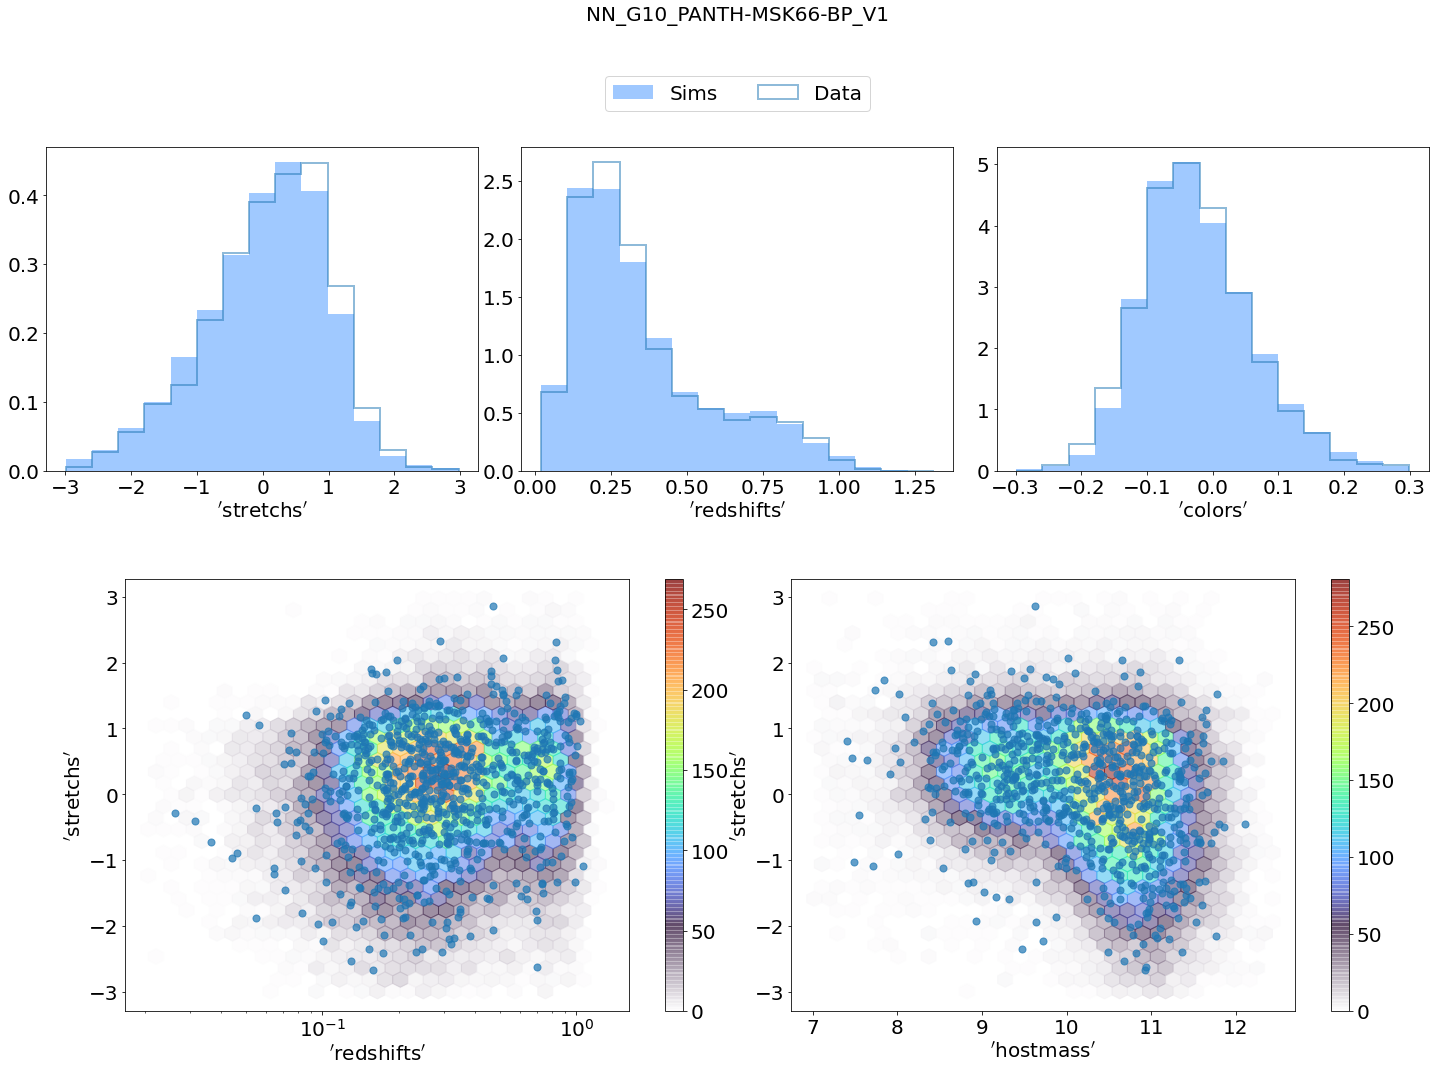

In [8]:
checkit.show_all()

Text(0.5, 0.98, 'NN_G10_PANTH-MSK66-BP_V1')

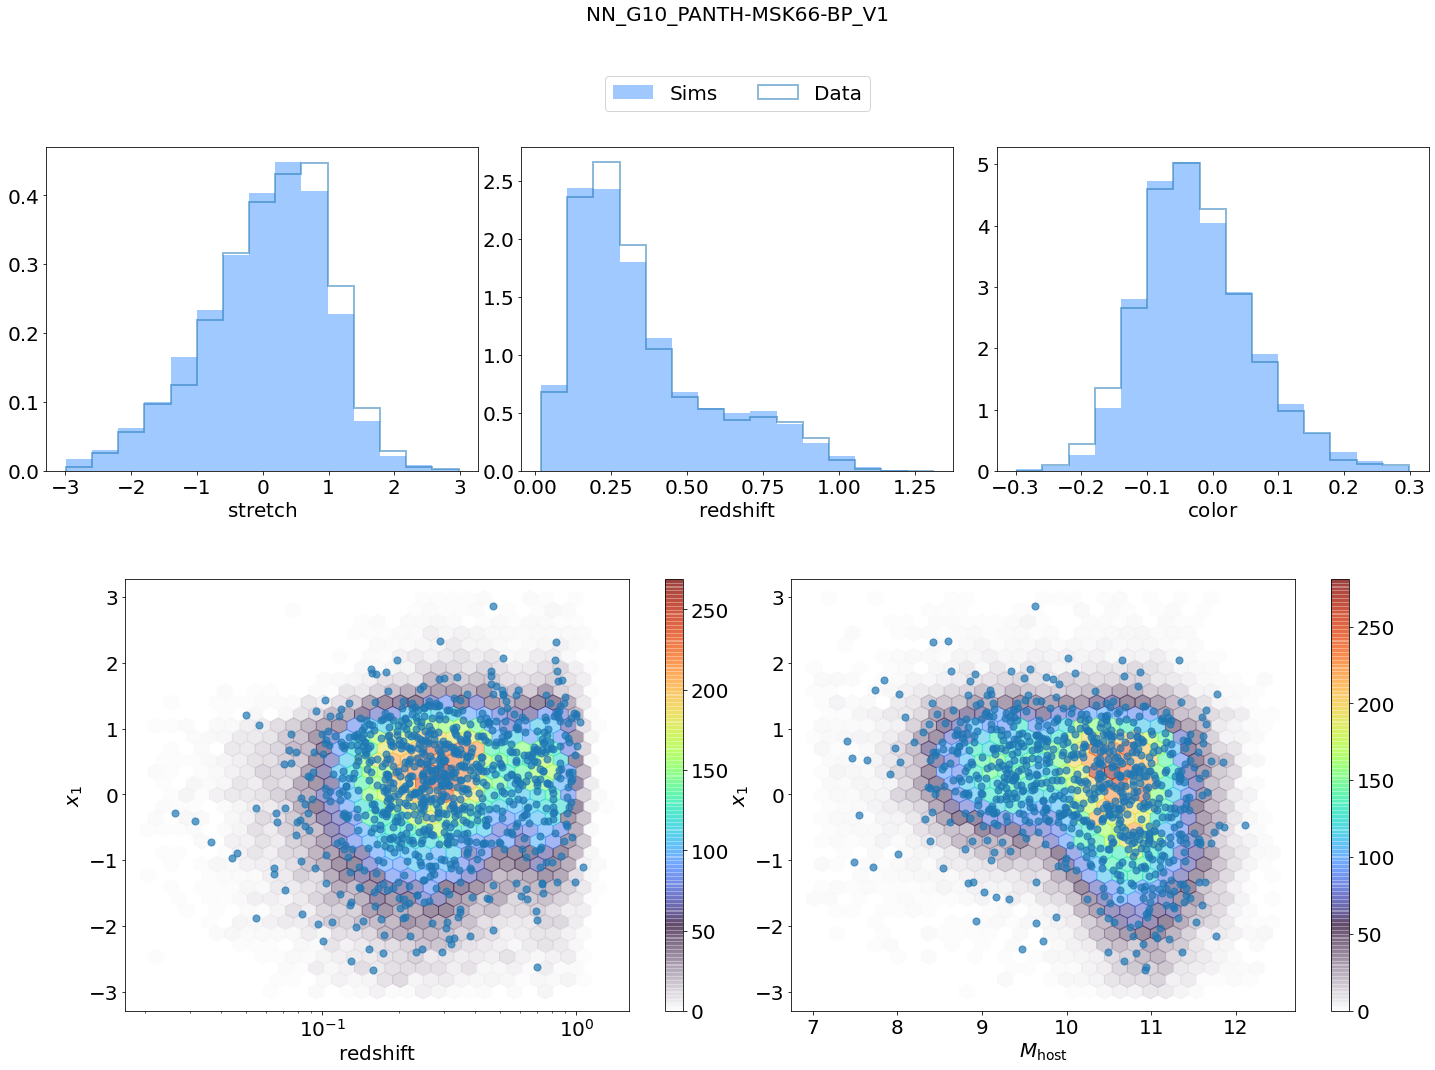

In [18]:
fig = plt.figure(figsize=[20, 15])

width_plot_cb = 0.35
space_cb = 0.025
width_cb = 0.0125
xmin_bottom = 0.075
ymin_bottom = 0.05
height_plot_cb = 0.40

xmin_top = 0.02
ymin_top = 0.15 + height_plot_cb
width_plot = 0.30
space_plot = 0.03
height_plot = 0.30

ax4 = fig.add_axes([xmin_top, ymin_top,
                    width_plot, height_plot])

ax1 = fig.add_axes([ax4.get_position().get_points()[1][0] + space_plot, ymin_top,
                    width_plot, height_plot])

ax5 = fig.add_axes([ax1.get_position().get_points()[1][0] + space_plot, ymin_top,
                    width_plot, height_plot])

ax2 = fig.add_axes([xmin_bottom, ymin_bottom,
                    width_plot_cb, height_plot_cb])
axb = fig.add_axes([ax2.get_position().get_points()[1][0] + space_cb, ymin_bottom,
                    width_cb, height_plot_cb])

ax3 = fig.add_axes([axb.get_position().get_points()[1][0] + 3*space_cb, ymin_bottom,
                    width_plot_cb, height_plot_cb])
axc = fig.add_axes([ax3.get_position().get_points()[1][0] + space_cb, ymin_bottom,
                    width_cb, height_plot_cb])

df_full_data = df_full[~df_full['survey'].isin(['SNF', 'HST'])]

color_data = 'C0'

#############################################################################

prophist = dict(alpha=.5, density=True)
nbbins = 15

_, binsv, _ = ax1.hist(fitprop_data.zCMB,
                      histtype='stepfilled',
                       bins=nbbins,
                      facecolor=cmap_tpw(0.35),
                      edgecolor=None,
                      label='Sims',
                      **prophist)

ax1.hist(df_full_data.redshifts,
         bins=binsv,
         histtype='step', lw=2,
         color=color_data,
         label='Data',
         **prophist)

_, binsv, _ = ax4.hist(fitprop_data.x1,
                      histtype='stepfilled',
                       bins=nbbins,
                      facecolor=cmap_tpw(0.35),
                      edgecolor=None,
                      label='Sims',
                      **prophist)

ax4.hist(df_full_data.stretchs,
         bins=binsv,
         histtype='step', lw=2,
         color=color_data,
         label='Data',
         **prophist)


_, binsv, _ = ax5.hist(fitprop_data.c,
                      histtype='stepfilled',
                       bins=nbbins,
                      facecolor=cmap_tpw(0.35),
                      edgecolor=None,
                      label='Sims',
                      **prophist)

ax5.hist(df_full_data.colors,
         bins=binsv,
         histtype='step', lw=2,
         color=color_data,
         label='Data',
         **prophist)

#############################################################################

prop2d = dict(alpha=.5, gridsize=30, cmap=cmap_tpw)

hb2 = ax2.hexbin(fitprop_data.zCMB,
                 fitprop_data.x1,
                 xscale='log',
                 **prop2d)

cb2 = fig.colorbar(hb2, cax=axb)

prop = dict(marker="o", s=50, lw=1, alpha=.7, color=color_data)

ax2.scatter(df_full_data.redshifts,
            df_full_data.stretchs,
            label='Data', **prop)

#ax2.errorbar(df_full_data.redshifts,
#             df_full_data.stretchs,
#             yerr=df_full_data.stretchs_err,
#             ecolor='0.9', alpha=.5, ls='none')

#############################################################################

fitprop_data_mass7 = fitprop_data[fitprop_data['HOST_LOGMASS'] > 7]
df_full_data_mass7 = df_full_data[df_full_data['hostmass'] > 7]

hb3 = ax3.hexbin(fitprop_data_mass7.HOST_LOGMASS,
                 fitprop_data_mass7.x1,
                 **prop2d)

cb3 = ax3.figure.colorbar(hb3, cax=axc)

ax3.scatter(df_full_data_mass7.hostmass,
            df_full_data_mass7.stretchs,
            label='Data', **prop)

#############################################################################

ax1.tick_params(labelsize=20)
ax4.tick_params(labelsize=20)
ax5.tick_params(labelsize=20)
ax2.tick_params(labelsize=20)
cb2.ax.tick_params(labelsize=20)
ax3.tick_params(labelsize=20)
cb3.ax.tick_params(labelsize=20)

ax1.set_xlabel(r"$\mathrm{redshift}$", fontsize=20)
#ax1.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)

ax4.set_xlabel(r"$\mathrm{stretch}$", fontsize=20)
#ax4.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)

ax5.set_xlabel(r"$\mathrm{color}$", fontsize=20)
#ax5.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)

ax2.set_xlabel(r"$\mathrm{redshift}$", fontsize=20)
ax2.set_ylabel(r"$x_1$", fontsize=20)
#cb2.set_label('counts', fontsize=20)

ax3.set_xlabel(r"$M_\mathrm{host}$", fontsize=20)
ax3.set_ylabel(r"$x_1$", fontsize=20)
#cb3.set_label('counts', fontsize=20)

ax1.legend(fontsize=20, ncol=2,
           loc='upper center',
           bbox_to_anchor=(0.5, 1.0, 0.0, 0.25))

fig.suptitle(sc.value.split('/')[-1], fontsize=20)

#fig.savefig('../../../Images/pdf/fitprop_data_' +
#            sc.value.split('/')[-1] +
#            '_errcut-hb_height.pdf',
#            bbox_inches='tight')
#fig.savefig('../../../Images/png/fitprop_data_' +
#            sc.value.split('/')[-1] +
#            '_errcut-hb_height.png',
#            bbox_inches='tight', transparent=False)

In [91]:
fig = plt.figure(figsize=[10, 7])

df_full_data = df_full[~df_full['survey'].isin(['SNF', 'HST'])]

prop2d = dict(alpha=.5, gridsize=30, cmap=cmap_tpw)

#hb2 = plt.hexbin(fitprop_data.zCMB,
#                 fitprop_data.x1,
#                 xscale='log',
#                 **prop2d)
#
#hb2_loc = [[],[]]
#for i in range(len(hb2.get_paths())):
#    hb2_loc[0] = np.concatenate((hb2_loc[0],
#                                 np.array([hb2.get_paths()[i].vertices.T[0][3] +
#                                 (hb2.get_paths()[i].vertices.T[0][1] -
#                                  hb2.get_paths()[i].vertices.T[0][3])/2])))
#    hb2_loc[-1] = np.concatenate((hb2_loc[-1],
#                                  np.array([hb2.get_paths()[i].vertices.T[-1][0] -
#                                  (hb2.get_paths()[i].vertices.T[-1][0] -
#                                   hb2.get_paths()[i].vertices.T[-1][1])/2])))
#    
#hb2_f = spline(hb2_loc[0], hb2_loc[1], hb2.get_array())
#
#hb2_height = [hb2_f(hb2_loc[0][i],
#                    hb2_loc[-1][i])[0]
#              for i in range(len(hb2_loc[0]))]
#
##ax2.scatter(hb2_loc[0], hb2_loc[-1], c=hb2.get_array(), cmap=cmap_tpw)
##ax2.scatter(hb2_loc[0], hb2_loc[-1],
##            alpha=.5,
##            c=hb2_height, cmap=cmap_tpw)
#
#xnew = np.linspace(np.min(hb2_loc[0]), np.max(hb2_loc[0]), 100)
#ynew = np.linspace(np.min(hb2_loc[1]), np.max(hb2_loc[1]), 100)
#znew = hb2_f(xnew, ynew)
#
##for i in range(100):
##    ax2.scatter(xnew, [ynew[i] for k in range(100)],
##                c=znew[i, :], cmap=cmap_tpw)
#
#plt.xscale('log')

##################################################################################
fig = plt.figure(figsize=[10, 7])

fitprop_data_mass7 = fitprop_data[fitprop_data['HOST_LOGMASS'] > 7]
df_full_data_mass7 = df_full_data[df_full_data['hostmass'] > 7]

#hb3 = plt.hexbin(fitprop_data_mass7.HOST_LOGMASS,
#                 fitprop_data_mass7.x1,
#                 **prop2d)

hb3_loc = hb3.get_offsets()
hb3_val = hb3.get_array()

hb3_f = spline(hb3_loc.T[0], hb3_loc.T[1], hb3_val)#, kind='quintic')

hb3_height = [hb3_f(hb3_loc.T[0][i],
                    hb3_loc.T[-1][i])[0]
              for i in range(len(hb3_loc))]

xnew_3 = np.linspace(np.min(hb3_loc.T[0]), np.max(hb3_loc.T[0]), 100)
ynew_3 = np.linspace(np.min(hb3_loc.T[1]), np.max(hb3_loc.T[1]), 100)
#xy = np.array(np.meshgrid(xnew_3, ynew_3, sparse=False))
xy = np.mgrid[np.min(hb3_loc.T[0]):np.max(hb3_loc.T[0]):0.25,
              np.min(hb3_loc.T[1]):np.max(hb3_loc.T[1]):0.25]

init_shape = np.shape(xy)
xypix = xy.reshape(2, init_shape[1]*init_shape[2])
znew_3 = hb3_f(xypix[0], xypix[1])

#for i in range(100):
#    plt.scatter(xnew_3, [ynew_3[i] for k in range(100)],
#                c=znew_3[i, :], cmap=cmap_tpw, alpha=.3)
#    
##plt.scatter(hb3_loc.T[0], hb3_loc.T[-1], c=hb3_val, cmap=cmap_tpw)
#tt = plt.scatter(hb3_loc.T[0], hb3_loc.T[-1],
#                 alpha=.7,
#                 c=hb3_height, cmap=cmap_tpw)
#
#fig.colorbar(tt)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=33,37 m=1068 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

In [86]:
znew_3[90][80]

138.697460856185

In [87]:
znew_3[80][90]


242.9893809065842

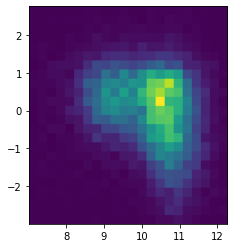

In [92]:
fig = plt.figure()
plt.imshow(znew_3, origin='lower',
           extent=(xypix[0][0], xypix[0][-1],
                   xypix[-1][0], xypix[-1][-1]))

In [131]:
np.sum(kernel([df_full['hostmass'], df_full['stretchs']]))

95.68731314126008

In [115]:
m1 = fitprop_data['HOST_LOGMASS']
m2 = fitprop_data['x1']
xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()
d1 = df_full_data['hostmass']
d2 = df_full_data['stretchs']

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
data = np.vstack([d1, d2])

kernel = stats.gaussian_kde(values)

Z = np.reshape(kernel(positions), X.shape)
#Z_data = np.reshape(kernel(data), X.shape)

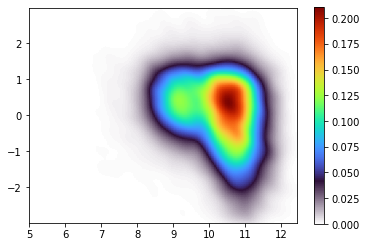

In [116]:
fig, ax = plt.subplots()

ims = ax.imshow(np.rot90(Z), cmap=cmap_tpw,
                extent=[xmin, xmax, ymin, ymax])

#ax.plot(m1, m2, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

fig.colorbar(ims)

plt.show()

In [125]:
def kernel_toint(x, y):
    return kernel([x, y])

In [129]:
scipy.integrate.dblquad(kernel_toint,
                        xmin, xmax,
                        lambda x: ymin, lambda x: ymax)

(8.862806696371886e-134, 7.658969660975752e-132)

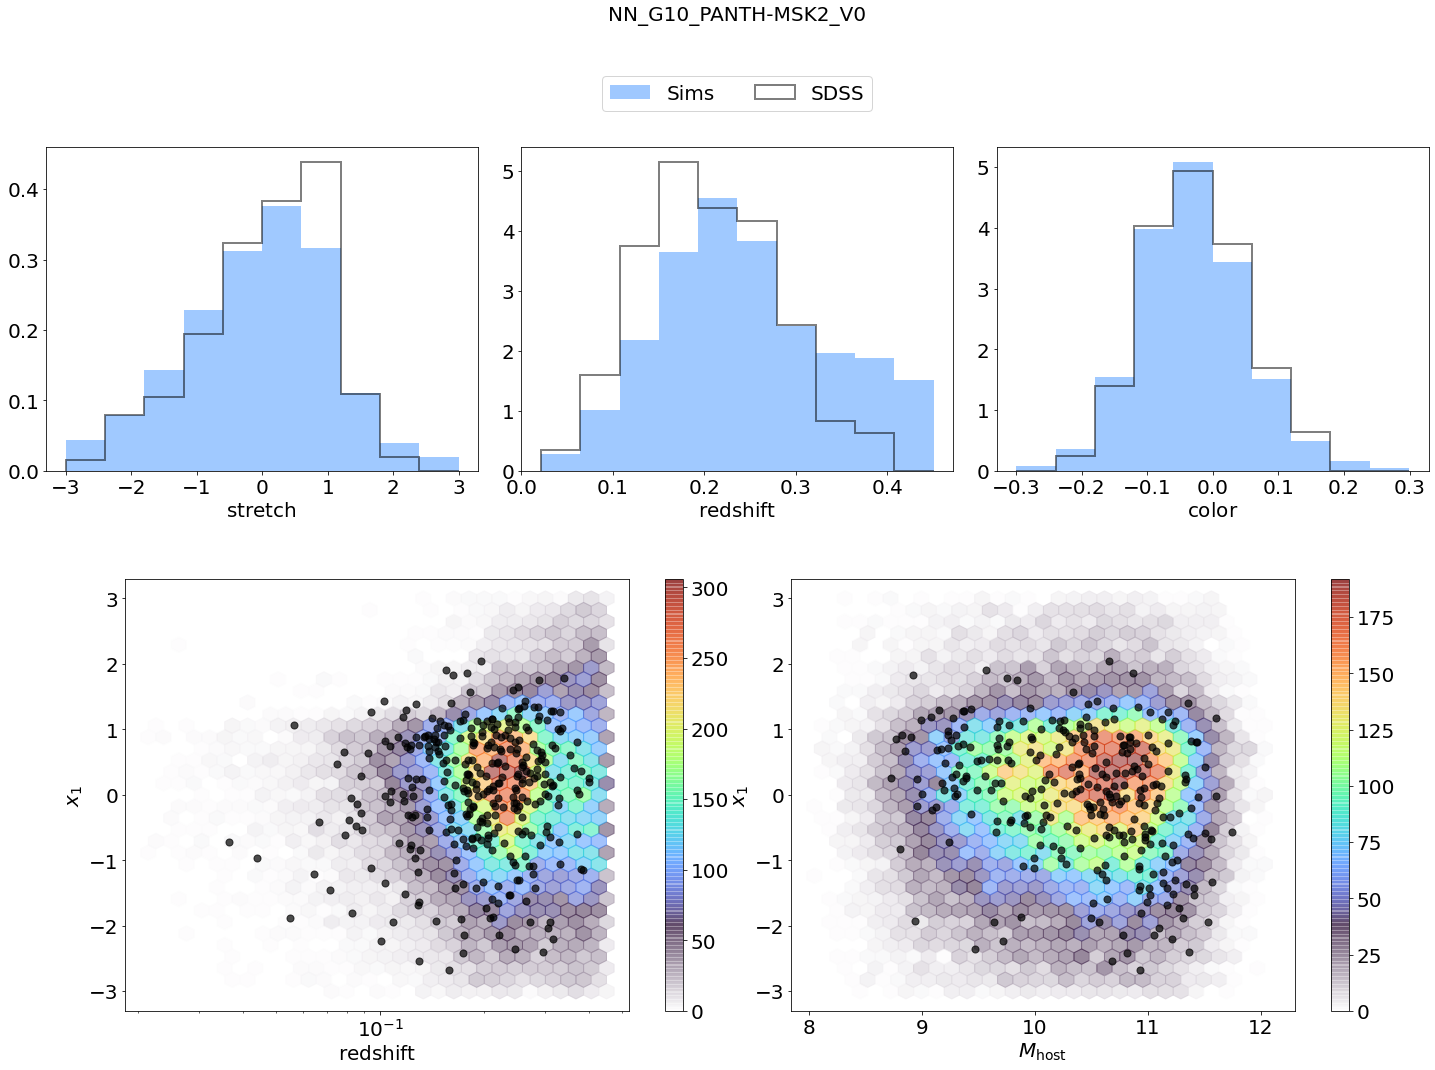

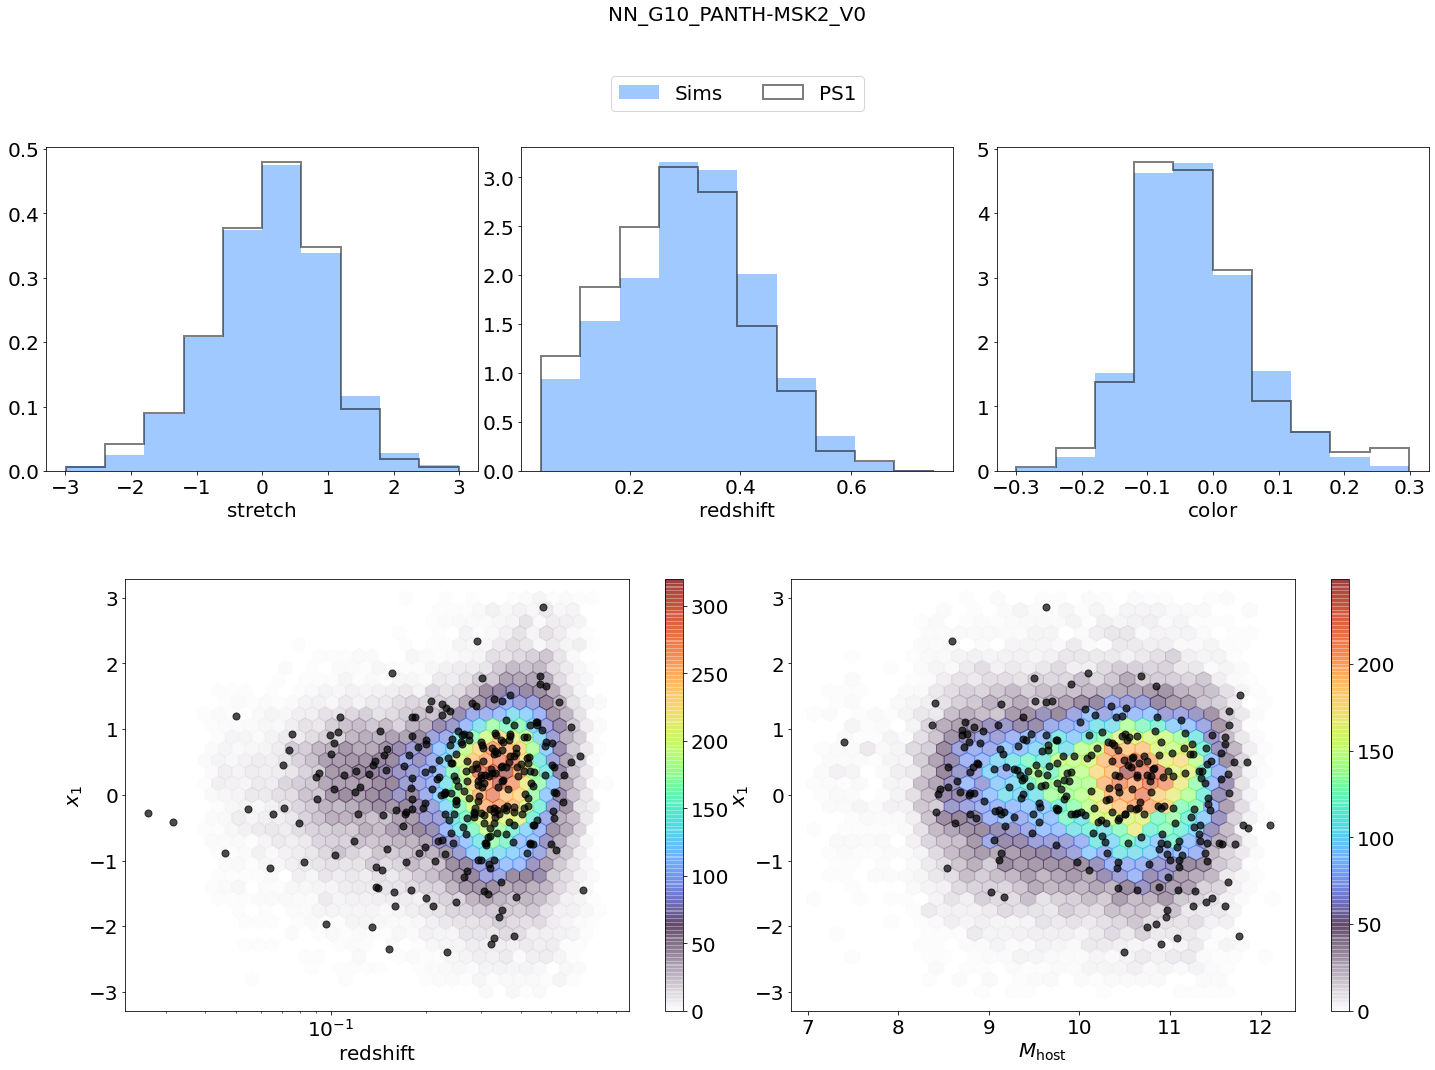

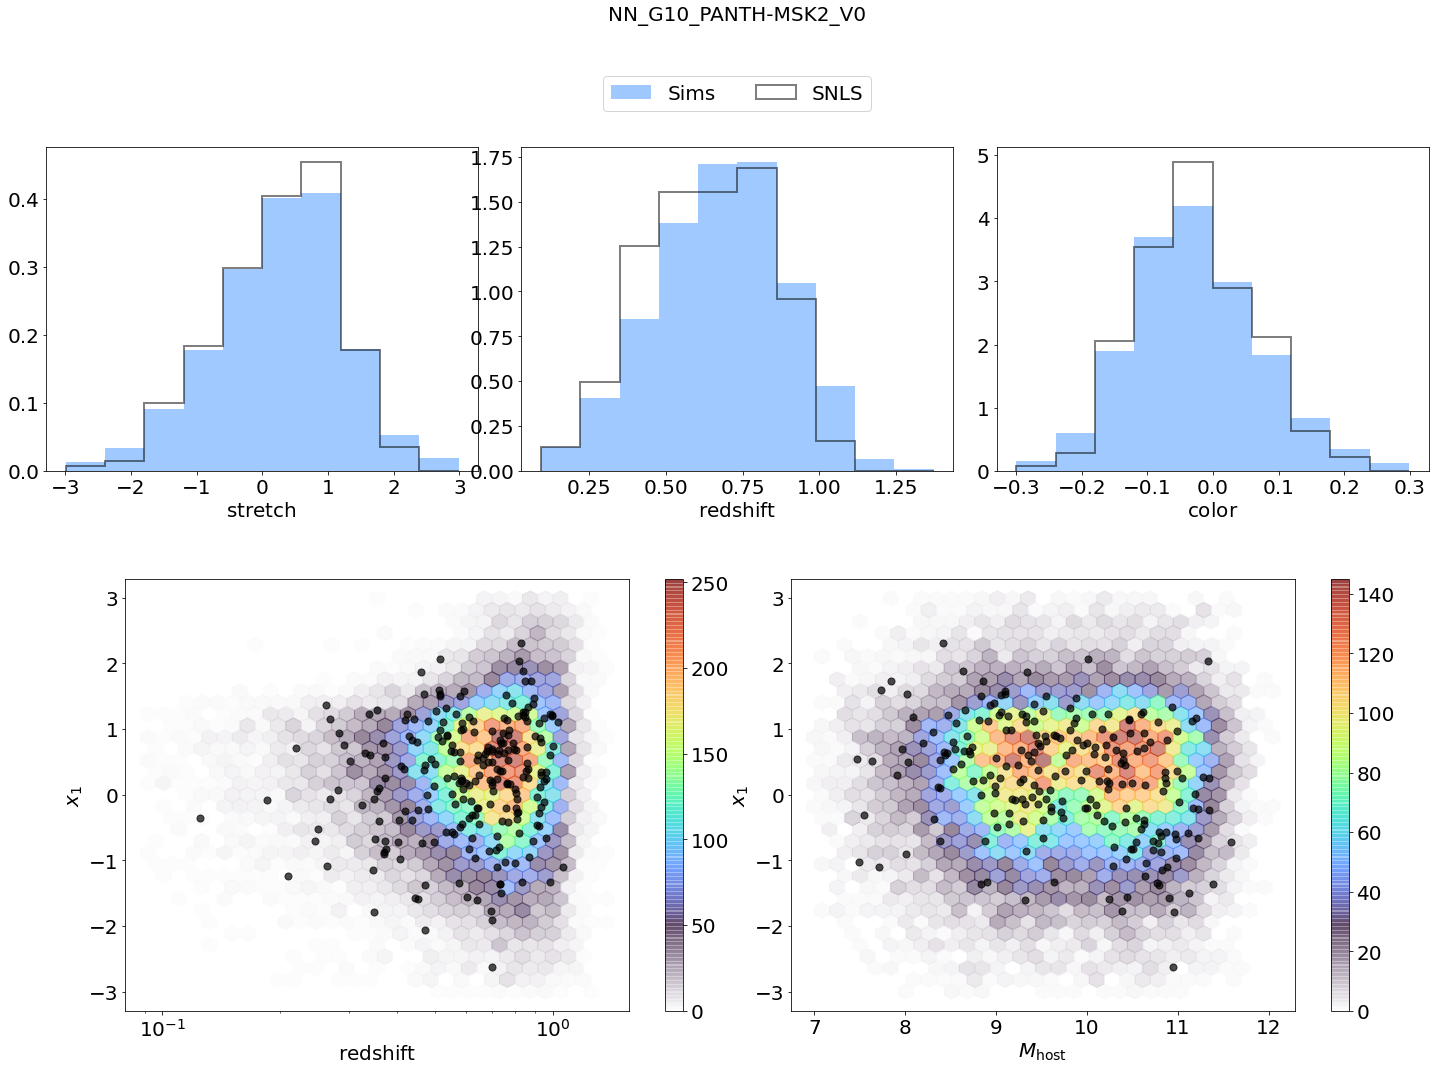

In [54]:
width_plot_cb = 0.35
space_cb = 0.025
width_cb = 0.0125
xmin_bottom = 0.075
ymin_bottom = 0.05
height_plot_cb = 0.40

xmin_top = 0.02
ymin_top = 0.15 + height_plot_cb
width_plot = 0.30
space_plot = 0.03
height_plot = 0.30

for i, zipped in enumerate(zip(surveys[1:-1], [1, 15, 4])):
    survey = zipped[0]
    idsurvey = zipped[-1]
    fig = plt.figure(figsize=[20, 15])
    
    ax4 = fig.add_axes([xmin_top, ymin_top,
                        width_plot, height_plot])
    
    ax1 = fig.add_axes([ax4.get_position().get_points()[1][0]
                        + space_plot, ymin_top,
                        width_plot, height_plot])
    
    ax5 = fig.add_axes([ax1.get_position().get_points()[1][0]
                        + space_plot, ymin_top,
                        width_plot, height_plot])
    
    ax2 = fig.add_axes([xmin_bottom, ymin_bottom,
                        width_plot_cb, height_plot_cb])
    axb = fig.add_axes([ax2.get_position().get_points()[1][0]
                        + space_cb, ymin_bottom,
                        width_cb, height_plot_cb])
    
    ax3 = fig.add_axes([axb.get_position().get_points()[1][0]
                        + 3*space_cb, ymin_bottom,
                        width_plot_cb, height_plot_cb])
    axc = fig.add_axes([ax3.get_position().get_points()[1][0]
                        + space_cb, ymin_bottom,
                        width_cb, height_plot_cb])
    
    df_full_data_used = df_full[df_full['survey'] == survey]
    fitprop_data_used = fitprop_data[fitprop_data['IDSURVEY'] == idsurvey]
    
    color_data = 'k'
    
    #############################################################################
    
    prophist = dict(alpha=.5, density=True)
    
    _, bins, _ = ax1.hist(fitprop_data_used.zCMB,
                          histtype='stepfilled',
                          facecolor=cmap_tpw(0.35),
                          edgecolor=None,
                          label='Sims',
                          **prophist)
    
    ax1.hist(df_full_data_used.redshifts,
             bins=bins,
             histtype='step', lw=2,
             color=color_data,
             label=survey,
             **prophist)
    
    _, bins, _ = ax4.hist(fitprop_data_used.x1,
                          histtype='stepfilled',
                          facecolor=cmap_tpw(0.35),
                          edgecolor=None,
                          label='Sims',
                          **prophist)
    
    ax4.hist(df_full_data_used.stretchs,
             bins=bins,
             histtype='step', lw=2,
             color=color_data,
             label=survey,
             **prophist)
    
    
    _, bins, _ = ax5.hist(fitprop_data_used.c,
                          histtype='stepfilled',
                          facecolor=cmap_tpw(0.35),
                          edgecolor=None,
                          label='Sims',
                          **prophist)
    
    ax5.hist(df_full_data_used.colors,
             bins=bins,
             histtype='step', lw=2,
             color=color_data,
             label=survey,
             **prophist)
    
    #############################################################################
    
    prop2d = dict(alpha=.5, gridsize=30, cmap=cmap_tpw)
    
    
    hb2 = ax2.hexbin(fitprop_data_used.zCMB,
                     fitprop_data_used.x1,
                     xscale='log',
                     **prop2d)
    ax2.set_xscale('log')
    
    cb2 = fig.colorbar(hb2, cax=axb)
    
    prop = dict(marker="o", s=50, lw=1, alpha=.7, color=color_data)
    
    ax2.scatter(df_full_data_used.redshifts,
                df_full_data_used.stretchs,
                label=survey, **prop)
    
    #############################################################################
    
    fitprop_data_used_mass7 = fitprop_data_used[fitprop_data_used['HOST_LOGMASS'] > 7]
    df_full_data_used_mass7 = df_full_data_used[df_full_data_used['hostmass'] > 7]
    
    hb3 = ax3.hexbin(fitprop_data_used_mass7.HOST_LOGMASS,
                     fitprop_data_used_mass7.x1,
                     **prop2d)
    
    cb3 = fig.colorbar(hb3, cax=axc)
    
    ax3.scatter(df_full_data_used_mass7.hostmass,
                df_full_data_used_mass7.stretchs,
                label=survey, **prop)
    #############################################################################
    
    ax1.tick_params(labelsize=20)
    ax4.tick_params(labelsize=20)
    ax5.tick_params(labelsize=20)
    ax2.tick_params(labelsize=20)
    cb2.ax.tick_params(labelsize=20)
    ax3.tick_params(labelsize=20)
    cb3.ax.tick_params(labelsize=20)
    
    ax1.set_xlabel(r"$\mathrm{redshift}$ ", fontsize=20)
    #ax1.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)
    
    ax4.set_xlabel(r"$\mathrm{stretch}$ ", fontsize=20)
    #ax4.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)
    
    ax5.set_xlabel(r"$\mathrm{color}$ ", fontsize=20)
    #ax5.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize=20)
    
    ax2.set_xlabel(r"$\mathrm{redshift}$ ", fontsize=20)
    ax2.set_ylabel(r"$x_1$", fontsize=20)
    #cb2.set_label('counts', fontsize=20)
    
    ax3.set_xlabel(r"$M_\mathrm{host}$ ", fontsize=20)
    ax3.set_ylabel(r"$x_1$", fontsize=20)
    #cb3.set_label('counts', fontsize=20)
    
    ax1.legend(fontsize=20, ncol=2,
               loc='upper center',
               bbox_to_anchor=(0.5, 1.0, 0.0, 0.25))
    
    fig.suptitle(sc.value.split('/')[-1], fontsize=20)
    
    fig.savefig('../../../Images/pdf/fitprop_data_' + sc.value.split('/')[-1]
                + '_' + survey + '.pdf',
                bbox_inches='tight')
    fig.savefig('../../../Images/png/fitprop_data_' + sc.value.split('/')[-1]
                + '_' + survey + '.png',
                bbox_inches='tight', transparent=False)

## `age` module testing

In [2]:
pdmodel = age.PrompDelayModel()
pdmodel.draw_sample(z=0.04, size=1000)

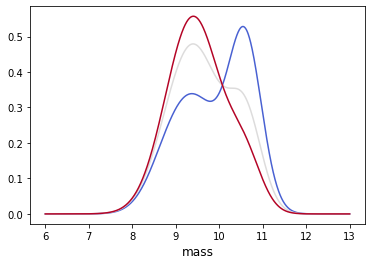

In [6]:
fig = pdmodel.show_pdf("mass", z=[0.05, 0.5, 1], zmax=1)

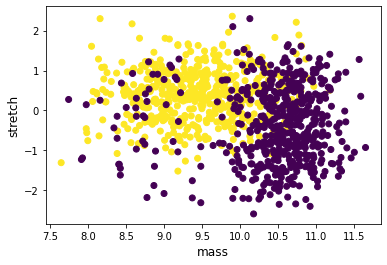

In [13]:
fig = pdmodel.show_scatter("mass","stretch", colorkey="age")

## Fit mass Brodie

In [4]:
with open('../../../Data/sne/lowz_df', 'rb') as f:
    lowz_df = pickle.load(f)

In [50]:
lowz_df['hg_masserr_nr'] = np.sqrt((lowz_df['hg_masserr_nr_down']**2
                                    + lowz_df['hg_masserr_nr_up']**2)/2)

In [51]:
lowz_df_fit = lowz_df.copy()
lowz_df_fit

In [46]:
lowz_df_fit.rename(columns={'zcmb': 'redshifts',
                            'hg_mass_nr': 'hostmass';
                            'hg_masserr_nr': 'hostmass_err'})

,CID,ra,dec,zcmb,hg_mass_sco,hg_masserr_sco,hg_mass_nr,hg_masserr_nr_down,hg_masserr_nr_up
0,2001ah,167.624,55.1608,0.05891,11.141,0.02,11.733746,0.100610,0.102540
1,2001az,248.614,76.0295,0.04059,11.376,0.059,11.563016,0.098809,0.099862
2,2001da,358.386,8.11728,0.01647,11.006,0.042,11.246402,0.100754,0.099997
3,2001en,21.3452,34.025,0.01544,11.133,0.078,11.390831,0.098434,0.100087
4,2001fe,144.488,25.4947,0.01449,10.277,0.095,11.013707,0.100463,0.099176
...,...,...,...,...,...,...,...,...,...
165,2000B,106.417,50.5888,0.02045,11.44,2.78,12.175438,0.098304,0.098759
166,2000cf,238.248,65.9378,0.03646,10.1732,0.2809,10.743448,0.098631,0.099377
167,2000cn,269.425,27.8257,0.02321,10.9619,0.2809,11.172982,0.100555,0.099259
168,2000dk,16.8446,32.4111,0.01602,10.4766,0.3742,12.195576,0.099497,0.099416


In [64]:
base_model = massevol.Evol3G3M3S(df)
base_model.minimize(limit_a=(0,1))
print(base_model.param)

{'mu_1': 9.42435033203514, 'sigma_1': 0.6352164641545026, 'a': 0.902710356796472, 'mu_2': 10.59321817727873, 'sigma_2': 0.3739487056160915, 'mu_3': 8.74496390066, 'sigma_3': 0.42788950723936164}


In [63]:
with open('../../../Data/mass/snf_mass', 'rb') as f:
    snf_mass = pickle.load(f)

No handles with labels found to put in legend.
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in log


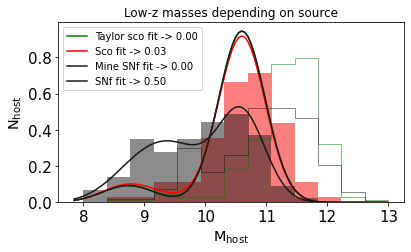

In [67]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

prop_hist = dict(bins=13, range=[8, 13], alpha=.5, density=True)

lowz_df_nr_sup8 = lowz_df[lowz_df['hg_mass_nr'] > 8]
ax.hist(lowz_df_nr_sup8['hg_mass_nr'],
        histtype='step',
        color='g',
        **prop_hist)

lowz_df_sco_sup8 = lowz_df[lowz_df['hg_mass_sco'] > 8]
ax.hist(lowz_df_sco_sup8['hg_mass_sco'],
        color=colors['low-z'],
        **prop_hist)

ax.hist(snf_mass[:, 0],
        color=colors['SNF'],
        **prop_hist,
        histtype='step')

ax.hist(df['hostmass'],
        color=colors['SNF'],
        **prop_hist)

ax.tick_params(labelsize=15)

ax.set_xlabel(r"$\mathrm{M}_\mathrm{host}$", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{N}_\mathrm{host}$", fontsize="x-large")

ax.legend(loc='upper left')

plt.title('Low-z masses depending on source')

def pdf_mass(x, fprompt):
    prompt_pdf = scipy.stats.norm.pdf(x,
                                      loc=9.41,
                                      scale=0.62)

    delay_pdf1 = scipy.stats.norm.pdf(x,
                                      loc=10.60,
                                      scale=0.38)

    delay_pdf2 = scipy.stats.norm.pdf(x,
                                      loc=8.74,
                                      scale=0.43)

    return(fprompt * prompt_pdf +
           (1-fprompt) * (0.90*delay_pdf1 + (1-0.90)*delay_pdf2))

def loglikepdf_mass_nr(fprompt):
    return -2*np.sum(np.log(pdf_mass(lowz_df_nr_sup8['hg_mass_nr'], fprompt)))

hg_sco_nparray = [lowz_df_sco_sup8['hg_mass_sco'].values[i]
                  for i in range(len(lowz_df_sco_sup8))]
def loglikepdf_mass_sco(fprompt):
    return -2*np.sum(np.log(pdf_mass(hg_sco_nparray, fprompt)))

def loglikepdf_mass_snf_mine(fprompt):
    return -2*np.sum(np.log(pdf_mass(snf_mass[:, 0], fprompt)))

def loglikepdf_mass_snf(fprompt):
    return -2*np.sum(np.log(pdf_mass(df['hostmass'], fprompt)))

def minimize_pdf_mass_nr(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass_nr,
                      print_level=print_level,
                      pedantic=False,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

def minimize_pdf_mass_sco(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass_sco,
                      print_level=print_level,
                      pedantic=False,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

def minimize_pdf_mass_snf_mine(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass_snf_mine,
                      print_level=print_level,
                      pedantic=False,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

def minimize_pdf_mass_snf(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass_snf,
                      print_level=print_level,
                      pedantic=False,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

bestfit_mass_nr = minimize_pdf_mass_nr().values['fprompt']
bestfit_mass_sco = minimize_pdf_mass_sco().values['fprompt']
bestfit_mass_snf_mine = minimize_pdf_mass_snf_mine().values['fprompt']
bestfit_mass_snf = minimize_pdf_mass_snf().values['fprompt']

xlin = np.linspace(7.85, 12.98, 100)
ax.plot(xlin,
        pdf_mass(xlin, bestfit_mass_nr),
        color='g',
        label=f'Taylor sco fit -> {bestfit_mass_nr:.2f}')
ax.plot(xlin,
        pdf_mass(xlin, bestfit_mass_sco),
        color=colors['low-z'],
        label=f'Sco fit -> {bestfit_mass_sco:.2f}')
ax.plot(xlin,
        pdf_mass(xlin, bestfit_mass_snf_mine),
        color=colors['SNF'],
        label=f'Mine SNf fit -> {bestfit_mass_snf_mine:.2f}')
ax.plot(xlin,
        pdf_mass(xlin, bestfit_mass_snf),
        color=colors['SNF'],
        label=f'SNf fit -> {bestfit_mass_snf:.2f}')

ax.legend(loc='upper left')

#ax.plot(x, x, '--', linewidth=5, color='firebrick')
fig.savefig('../../../Images/pdf/mass_hists-fitted.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/mass_hists-fitted.png', bbox_inches='tight', dpi=600)

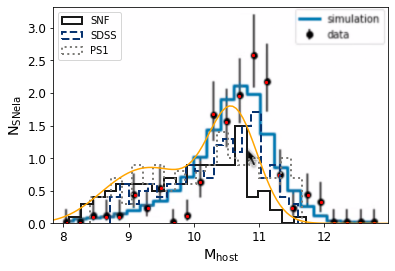

In [70]:
img = plt.imread("../../../Images/png/mass_hist_lowz_crop_zero.png")
fig, ax = plt.subplots()

Mmin = 7.85
Mmax = 12.98
Cmin = 0
Cmax = 170
f = 85.185

Mlist = [8.05, 8.25, 8.45, 8.65, 8.85,
         9.1, 9.3, 9.5, 9.7, 9.9,
         10.1, 10.3, 10.5, 10.7, 10.9,
         11.1, 11.3, 11.5, 11.75, 11.95,
         12.15, 12.35, 12.55, 12.76]

ax.scatter(Mlist,
           np.asarray([0, 0, 8, 8, 8,
                       37, 20, 46, 0, 10,
                       54, 143, 132, 166, 220,
                       185, 63, 20, 37, 28,
                       1, 0, 0, 0])/f,
          color='red', s=5)
ax.imshow(img, extent=[Mmin, Mmax, 0, 3.32])
          #[7.81, 12.94, 0, 170])

#ax.set_xlim([7.81, 12.94])
#ax.set_ylim([0, 170])

ax.tick_params(labelsize=12)

ax.set_xlabel(r'$\mathrm{M}_\mathrm{host}$', fontsize = 'x-large')
ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")

def pdf_mass(x, fprompt):
    prompt_pdf = scipy.stats.norm.pdf(x,
                                      loc=9.41,
                                      scale=0.62)

    delay_pdf1 = scipy.stats.norm.pdf(x,
                                      loc=10.60,
                                      scale=0.38)

    delay_pdf2 = scipy.stats.norm.pdf(x,
                                      loc=8.74,
                                      scale=0.43)

    return(fprompt * prompt_pdf +
           (1-fprompt) * (0.90*delay_pdf1 + (1-0.90)*delay_pdf2))

def loglikepdf_mass(fprompt):
    return -2*np.sum(np.log(pdf_mass(Mlist, fprompt)))

def minimize_pdf_mass(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikepdf_mass,
                      print_level=print_level,
                      pedantic=False,
                      fprompt=0.1,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

bestfit_mass = minimize_pdf_mass().values

xlin = np.linspace(7.85, 12.98, 100)
ax.plot(xlin,
        3*pdf_mass(xlin, bestfit_mass['fprompt']),
        color='orange')

ls = ['-', '--', ':']

for i, survey in enumerate(surveys[:3]):
    df_ncused = df_nc[df_nc['survey'] == survey]
    where = df_ncused['hostmass'] > 8
    df_cused = df_c[df_c['survey'] == survey]

    ax.hist(df_ncused[where].hostmass, bins=20,
            weights=[0.100 for i in range(len(df_ncused[where].hostmass))],
            histtype='step', lw=2, fill=False,
            zorder=1,
            edgecolor=colors[survey],
            facecolor=alphacolors(.5, survey),
            ls=ls[i], label=survey)
    
ax.legend(loc='upper left')

#ax.plot(x, x, '--', linewidth=5, color='firebrick')
#fig.savefig('../../../Images/png/mass_hist_lowz-fitted.png', bbox_inches='tight', dpi=600)

In [112]:
bestfit_mass['fprompt']

0.41157248447333517